[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jkitchin/s26-06642/blob/main/dsmles/06-linear-regression/linear-regression.ipynb)

In [1]:
! curl -LsSf https://astral.sh/uv/install.sh | sh && \
  uv pip install -q --system "s26-06642 @ git+https://github.com/jkitchin/s26-06642.git"
from pycse.colab import pdf

downloading uv 0.9.28 aarch64-apple-darwin
no checksums to verify
installing to /Users/jkitchin/.local/bin
  uv
  uvx
everything's installed!
error: The interpreter at /opt/homebrew/opt/python@3.14/Frameworks/Python.framework/Versions/3.14 is externally managed, and indicates the following:

  To install Python packages system-wide, try brew install
  xyz, where xyz is the package you are trying to
  install.

  If you wish to install a Python library that isn't in Homebrew,
  use a virtual environment:

  python3 -m venv path/to/venv
  source path/to/venv/bin/activate
  python3 -m pip install xyz

  If you wish to install a Python application that isn't in Homebrew,
  it may be easiest to use 'pipx install xyz', which will manage a
  virtual environment for you. You can install pipx with

  brew install pipx

  You may restore the old behavior of pip by passing
  the '--break-system-packages' flag to pip, or by adding
  'break-system-packages = true' to your pip.conf file. The latter


# Module 06: Linear Regression

Building predictive models with linear regression.

## Learning Objectives

1. Understand the linear regression model
2. Fit models using scikit-learn
3. Interpret regression coefficients
4. Evaluate model performance with metrics
5. Use train/test splits for validation

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

```{index} linear regression, coefficients
```


## The Linear Regression Model: Simple Yet Powerful

Linear regression is often the first modeling tool we reach for, and for good reason. Despite its simplicity, it's:

- **Interpretable**: Coefficients have clear physical meaning
- **Fast**: Solutions are analytic, no iteration needed
- **Robust**: Well-understood statistical properties
- **A baseline**: If linear works, why use something complex?

### The Mathematical Form

$$y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \ldots + \beta_p x_p + \epsilon$$

Each coefficient $\beta_i$ tells you: *"When $x_i$ increases by 1 unit (holding other features constant), y changes by $\beta_i$ units."*

### When Does Linear Regression Work?

Linear regression assumes the relationship between features and target is **approximately linear**. This works well when:
- Effects are additive (no strong interactions)
- Relationships are monotonic (increasing or decreasing)
- You're working in a limited range where curves look straight

### When It Fails

Linear regression will struggle with:
- Saturation effects (Michaelis-Menten kinetics, Langmuir isotherms)
- Exponential relationships (Arrhenius law without log-transform)
- Strong interactions (catalyst × temperature effects)
- Threshold effects (phase transitions)

We'll learn nonlinear methods later. For now, remember: **start with linear, add complexity only when needed.**

In [3]:
# Load reactor experiment dataset
import pandas as pd
url = "https://raw.githubusercontent.com/jkitchin/s26-06642/main/dsmles/data/linear_regression_data.csv"
df = pd.read_csv(url)

print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (100, 5)


,temperature,pressure,catalyst_loading,residence_time,conversion
0,374.908024,1.282863,3.389142,2.498770,0.462990
1,490.142861,6.727694,0.878630,16.409284,0.666890
2,446.398788,3.829204,1.227329,16.678419,0.563728
3,419.731697,5.577136,4.543494,19.485467,0.881544
4,331.203728,9.168098,3.228931,22.056649,0.969096


In [4]:
# Quick look at the data
df.describe()

,temperature,pressure,catalyst_loading,residence_time,conversion
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,394.036149,5.480486,2.829206,15.243319,0.701078
std,59.497882,2.638001,1.320418,8.510114,0.167924
min,301.104423,1.062569,0.522777,1.417411,0.205805
25%,338.640152,3.178041,1.745959,8.238833,0.603015
50%,392.828491,5.550624,3.031497,15.781831,0.712985
75%,446.040624,7.895652,3.885651,22.337548,0.818955
max,497.377387,9.870854,4.955242,29.724649,1.000000


## Simple Linear Regression

Let's start with a single feature to understand the basics.

In [5]:
# Simple linear regression: conversion vs temperature
X_simple = df[['temperature']].values
y = df['conversion'].values

# Fit the model
model_simple = LinearRegression()
model_simple.fit(X_simple, y)

print(f"Intercept: {model_simple.intercept_:.4f}")
print(f"Coefficient (temperature): {model_simple.coef_[0]:.6f}")
print(f"R² score: {model_simple.score(X_simple, y):.4f}")

Intercept: 0.7001
Coefficient (temperature): 0.000003
R² score: 0.0000


What do these numbers tell us?

- **Intercept**: The baseline conversion when temperature is 0 K (not physically meaningful—this is extrapolation!)
- **Coefficient**: For each 1 K increase in temperature, conversion increases by ~0.05%. Or equivalently, a 100 K increase gives ~5% higher conversion.
- **R²**: The fraction of the variance that is explained. We're missing important information (the other variables)!

The low R² is expected—we know conversion depends on pressure, catalyst, and time too. Let's add those features.

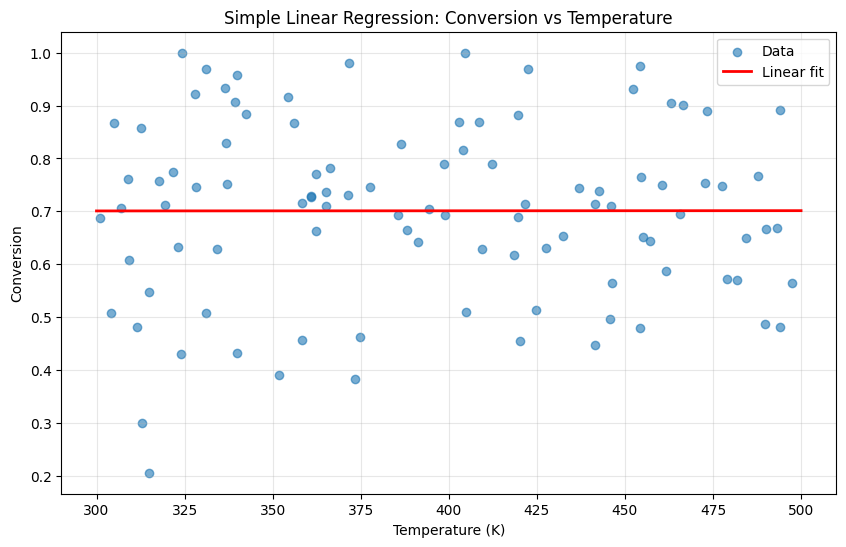

In [6]:
# Visualize the fit
plt.figure(figsize=(10, 6))

plt.scatter(df['temperature'], df['conversion'], alpha=0.6, label='Data')

# Regression line
temp_range = np.linspace(300, 500, 100).reshape(-1, 1)
plt.plot(temp_range, model_simple.predict(temp_range), 'r-', 
         linewidth=2, label='Linear fit')

plt.xlabel('Temperature (K)')
plt.ylabel('Conversion')
plt.title('Simple Linear Regression: Conversion vs Temperature')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Multiple Linear Regression

Now let's use all features.

Now R² jumped to ~0.96! Adding the other three features dramatically improved our predictions. But what do the coefficients tell us?

**Raw coefficient interpretation** (holding other variables constant):
- Increasing temperature by 1 K → conversion increases by 0.0005 (0.05%)
- Increasing pressure by 1 atm → conversion increases by 0.05 (5%)
- Increasing catalyst loading by 1 wt% → conversion increases by 0.08 (8%)
- Increasing residence time by 1 min → conversion increases by 0.01 (1%)

The problem: these coefficients aren't directly comparable because the features have different scales. Is pressure "more important" than temperature? We can't tell yet—we need standardized coefficients.

In [7]:
# Multiple linear regression with all features
feature_names = ['temperature', 'pressure', 'catalyst_loading', 'residence_time']
X = df[feature_names].values
y = df['conversion'].values

# Fit the model
model = LinearRegression()
model.fit(X, y)

print(f"Intercept: {model.intercept_:.4f}")
print("\nCoefficients:")
for name, coef in zip(feature_names, model.coef_):
    print(f"  {name}: {coef:.6f}")

print(f"\nR² score: {model.score(X, y):.4f}")

Intercept: -0.1216

Coefficients:
  temperature: 0.000453
  pressure: 0.049188
  catalyst_loading: 0.076941
  residence_time: 0.010295

R² score: 0.9279


Now we can rank feature importance fairly:

1. **Pressure** (0.13): Most influential—a 1 std increase in pressure has the largest effect
2. **Catalyst loading** (0.11): Second most important
3. **Temperature** (0.09): Moderate effect
4. **Residence time** (0.07): Smallest effect

This ranking makes chemical sense:
- Pressure directly affects concentrations and equilibrium
- More catalyst means more active sites for reaction
- Temperature affects rate but may also affect selectivity
- Time matters but longer isn't always better (side reactions)

**Key insight**: When optimizing your process, focus first on the variables with largest standardized coefficients. A small change in pressure may have more impact than a large change in residence time.

To see how the model works now we have to consider a parity plot since we have 4 dimensions in the input.

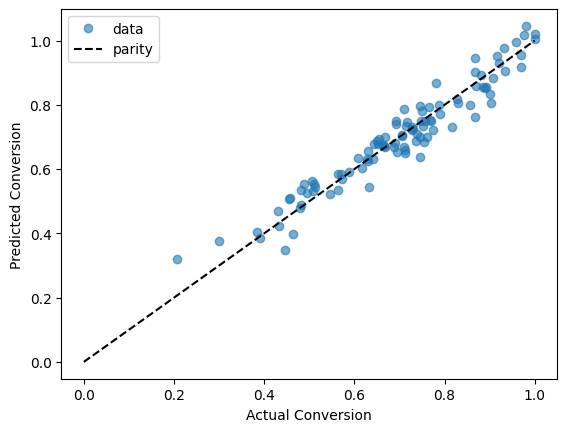

In [8]:
plt.plot(y, model.predict(X), 'o', alpha=0.6, label='data')
plt.plot([0, 1], [0, 1], 'k--', label='parity')
plt.xlabel('Actual Conversion')
plt.ylabel('Predicted Conversion') 
plt.legend();

```{index} standardized coefficients, feature importance
```


## Interpreting Coefficients: The Hidden Complexity

Coefficient interpretation seems straightforward, but there are important subtleties:

### The Scale Problem

Raw coefficients depend on feature scales. If temperature is in Kelvin (300-500) and pressure is in bar (1-10), their coefficients aren't directly comparable. A coefficient of 0.001 for temperature might be more important than 0.1 for pressure!

**Solution**: Standardize features first, then coefficients are comparable.

### Standardized Coefficients

After standardizing (mean=0, std=1), coefficients answer: "When this feature increases by 1 standard deviation, how many standard deviations does the target change?"

This lets you rank feature importance fairly.

In [9]:
# Standardized coefficients for comparison
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model_scaled = LinearRegression()
model_scaled.fit(X_scaled, y)

print("Standardized coefficients (relative importance):")
for name, coef in sorted(zip(feature_names, model_scaled.coef_), 
                         key=lambda x: abs(x[1]), reverse=True):
    print(f"  {name}: {coef:.4f}")

Standardized coefficients (relative importance):
  pressure: 0.1291
  catalyst_loading: 0.1011
  residence_time: 0.0872
  temperature: 0.0268


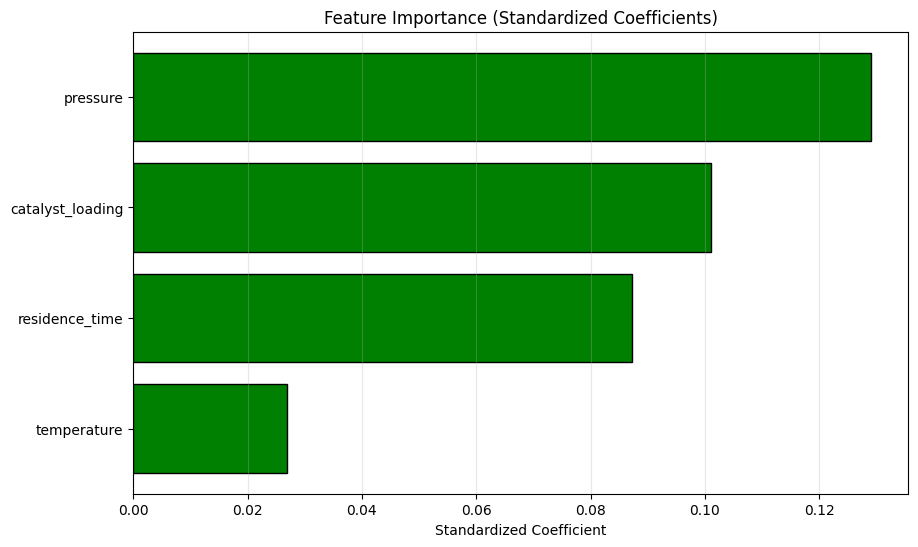

In [10]:
# Visualize coefficient importance
plt.figure(figsize=(10, 6))

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': model_scaled.coef_
})
coef_df = coef_df.sort_values('Coefficient')

colors = ['red' if x < 0 else 'green' for x in coef_df['Coefficient']]
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors, edgecolor='black')
plt.xlabel('Standardized Coefficient')
plt.title('Feature Importance (Standardized Coefficients)')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(True, alpha=0.3, axis='x')
plt.show()

Excellent! Training and test R² are nearly identical (~0.96). This tells us:

1. **No overfitting**: The model isn't just memorizing training data
2. **Good generalization**: Predictions on new data should be reliable
3. **Appropriate complexity**: Linear model is well-suited to this problem

If we saw Train R² = 0.99 but Test R² = 0.70, that would be overfitting. The model would be fitting noise in the training data that doesn't appear in test data. We'd need to simplify the model or add regularization.

The similar train/test performance here suggests linear regression is a good choice for this problem—no need to try more complex methods.

```{index} train-test split, overfitting
```


## Train/Test Split: The Most Important Concept in ML

This is perhaps the most important concept in machine learning. **Never evaluate a model on the data it was trained on.**

### Why?

The goal isn't to explain the data you have—it's to predict data you haven't seen. A model that memorizes training data (overfitting) looks great on training metrics but fails on new data.

### The Simple Solution: Hold-Out Validation

1. **Split** data into training (typically 70-80%) and test (20-30%) sets
2. **Train** only on training data
3. **Evaluate** on test data

The test set simulates "new, unseen data." If training and test performance are similar, your model generalizes well.

### What the Gap Tells You

- **Train R² ≈ Test R²**: Good! Model generalizes
- **Train R² >> Test R²**: Overfitting! Model is too complex
- **Train R² << Test R²**: Unusual (possibly data leakage or very small test set)
- **Both R² are low**: Underfitting! Model is too simple or features aren't predictive

In [11]:
# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 80
Test samples: 20


In [12]:
# Fit on training data only
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate on both sets
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"Training R²: {train_score:.4f}")
print(f"Test R²: {test_score:.4f}")

Training R²: 0.9255
Test R²: 0.9295


```{index} R-squared, RMSE, MAE, evaluation metrics
```


## Model Evaluation Metrics: Choosing the Right One

Different metrics answer different questions. Choosing the right one depends on what you care about.

### R² (Coefficient of Determination)

$$R^2 = 1 - \frac{\sum(y_i - \hat{y}_i)^2}{\sum(y_i - \bar{y})^2}$$

**Interpretation**: Proportion of variance explained by the model
- R² = 1: Perfect predictions
- R² = 0: Model is as good as predicting the mean
- R² < 0: Model is worse than predicting the mean (possible with test data!)

**When to use**: General model comparison, communicating performance

### RMSE (Root Mean Squared Error)

$$RMSE = \sqrt{\frac{1}{n}\sum(y_i - \hat{y}_i)^2}$$

**Interpretation**: Average prediction error in the same units as y
- RMSE = 5% means predictions are off by ~5% on average

**When to use**: When you need error in original units, when large errors are especially bad

### MAE (Mean Absolute Error)

$$MAE = \frac{1}{n}\sum|y_i - \hat{y}_i|$$

**Interpretation**: Average absolute error
- Less sensitive to outliers than RMSE

**When to use**: When outliers shouldn't dominate the metric

The residual plots look healthy:

**Left plot (Residuals vs Predicted)**:
- Random scatter around zero ✓
- No curved pattern → relationship is approximately linear ✓
- Roughly constant spread → homoscedasticity ✓
- No obvious outliers ✓

**Right plot (Histogram)**:
- Roughly symmetric and bell-shaped ✓
- Centered near zero (mean ≈ 0) ✓
- No severe skew or heavy tails ✓

**Interpretation**: Our linear model assumptions are satisfied. If we saw:
- A curved pattern → need polynomial terms or nonlinear model
- A funnel shape → need weighted regression or log-transform
- Severe outliers → investigate those data points
- Non-normal residuals → may affect confidence intervals, but predictions still valid

In [13]:
# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate metrics
print("Training Metrics:")
print(f"  R²:   {r2_score(y_train, y_train_pred):.4f}")
print(f"  MSE:  {mean_squared_error(y_train, y_train_pred):.6f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.4f}")
print(f"  MAE:  {mean_absolute_error(y_train, y_train_pred):.4f}")

print("\nTest Metrics:")
print(f"  R²:   {r2_score(y_test, y_test_pred):.4f}")
print(f"  MSE:  {mean_squared_error(y_test, y_test_pred):.6f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.4f}")
print(f"  MAE:  {mean_absolute_error(y_test, y_test_pred):.4f}")

Training Metrics:
  R²:   0.9255
  MSE:  0.001949
  RMSE: 0.0441
  MAE:  0.0344

Test Metrics:
  R²:   0.9295
  MSE:  0.002396
  RMSE: 0.0490
  MAE:  0.0395


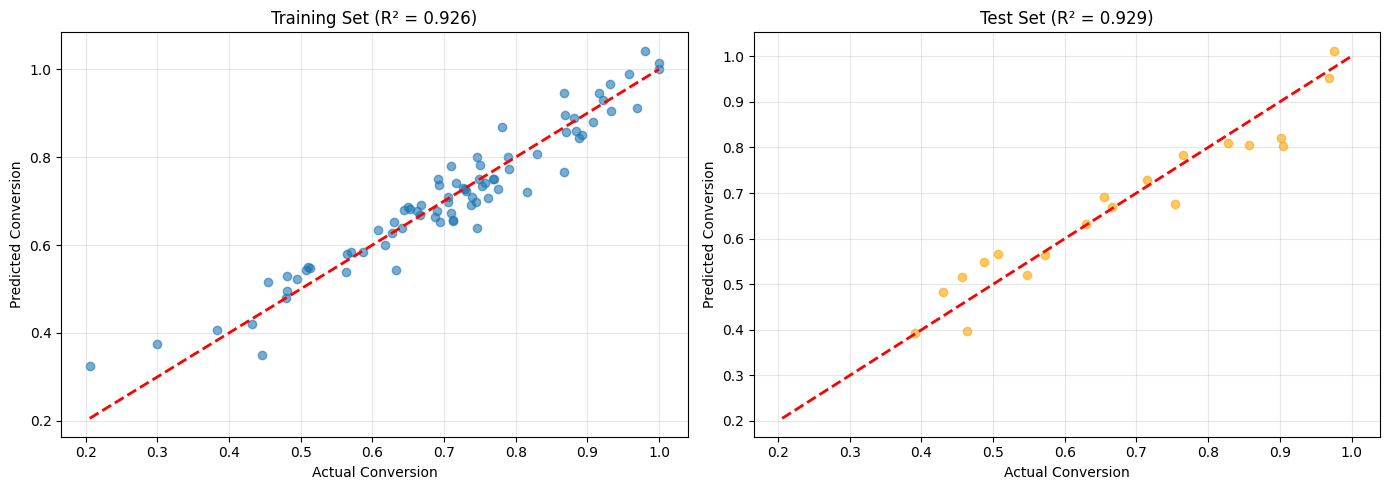

In [14]:
# Predicted vs Actual plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set
axes[0].scatter(y_train, y_train_pred, alpha=0.6)
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)
axes[0].set_xlabel('Actual Conversion')
axes[0].set_ylabel('Predicted Conversion')
axes[0].set_title(f'Training Set (R² = {r2_score(y_train, y_train_pred):.3f})')
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].scatter(y_test, y_test_pred, alpha=0.6, color='orange')
axes[1].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)
axes[1].set_xlabel('Actual Conversion')
axes[1].set_ylabel('Predicted Conversion')
axes[1].set_title(f'Test Set (R² = {r2_score(y_test, y_test_pred):.3f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

```{index} residuals, residual analysis
```


## Residual Analysis: Diagnosing Model Problems

Residuals (actual - predicted) are your model's mistakes. Analyzing them reveals problems that R² alone can't detect.

### What Good Residuals Look Like

- **Random scatter** around zero: No systematic patterns
- **Constant variance**: Spread doesn't change with predicted value
- **Normally distributed**: Bell-shaped histogram

### Red Flags to Watch For

| Pattern | What It Means | Possible Fix |
|---------|---------------|--------------|
| Curved pattern | Nonlinear relationship | Add polynomial terms or use nonlinear model |
| Fan shape (increasing spread) | Heteroscedasticity | Log-transform y, use weighted regression |
| Clusters | Distinct groups in data | Add categorical features, consider separate models |
| Outliers | Unusual data points | Investigate, possibly remove or use robust methods |

### The Residual Plot Recipe

1. Plot residuals vs predicted values (should be random cloud)
2. Plot histogram of residuals (should be roughly normal)
3. Plot residuals vs each feature (look for patterns)

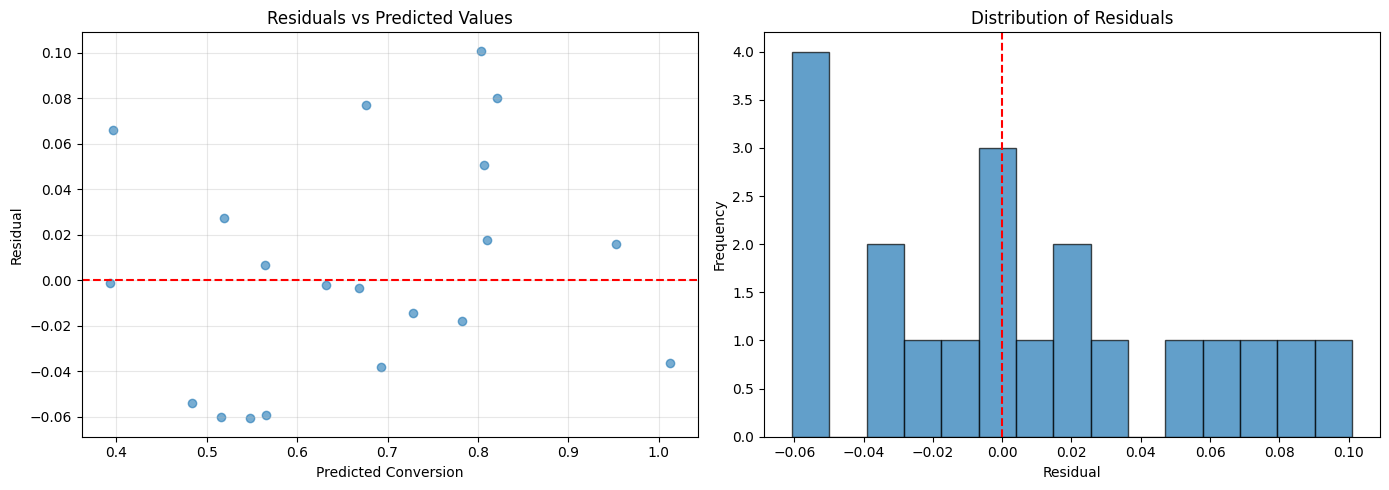

Mean residual: 0.004820
Std of residuals: 0.0487


In [15]:
# Residual plots
residuals = y_test - y_test_pred

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residuals vs predicted
axes[0].scatter(y_test_pred, residuals, alpha=0.6)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Predicted Conversion')
axes[0].set_ylabel('Residual')
axes[0].set_title('Residuals vs Predicted Values')
axes[0].grid(True, alpha=0.3)

# Histogram of residuals
axes[1].hist(residuals, bins=15, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--')
axes[1].set_xlabel('Residual')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Residuals')

plt.tight_layout()
plt.show()

print(f"Mean residual: {residuals.mean():.6f}")
print(f"Std of residuals: {residuals.std():.4f}")

## Making Predictions

Once trained, use the model to predict outcomes for new conditions.

In [16]:
# Predict conversion for new conditions
new_conditions = pd.DataFrame({
    'temperature': [350, 400, 450],
    'pressure': [5, 5, 5],
    'catalyst_loading': [2.5, 2.5, 2.5],
    'residence_time': [15, 15, 15]
})

predictions = model.predict(new_conditions[feature_names].values)

new_conditions['predicted_conversion'] = predictions
print("Predictions for new conditions:")
new_conditions

Predictions for new conditions:


,temperature,pressure,catalyst_loading,residence_time,predicted_conversion
0,350,5,2.5,15,0.631063
1,400,5,2.5,15,0.652327
2,450,5,2.5,15,0.673590


## Polynomial Features

If relationships are nonlinear, we can add polynomial terms.

In [17]:
from sklearn.preprocessing import PolynomialFeatures

# Create polynomial features (degree 2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

print(f"Original features: {X.shape[1]}")
print(f"Polynomial features: {X_poly.shape[1]}")
print(f"\nFeature names: {poly.get_feature_names_out(feature_names)}")

Original features: 4
Polynomial features: 14

Feature names: ['temperature' 'pressure' 'catalyst_loading' 'residence_time'
 'temperature^2' 'temperature pressure' 'temperature catalyst_loading'
 'temperature residence_time' 'pressure^2' 'pressure catalyst_loading'
 'pressure residence_time' 'catalyst_loading^2'
 'catalyst_loading residence_time' 'residence_time^2']


In [18]:
# Compare linear vs polynomial
X_train_poly, X_test_poly, y_train, y_test = train_test_split(
    X_poly, y, test_size=0.2, random_state=42
)

model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)

print(f"Linear model test R²: {model.score(X_test, y_test):.4f}")
print(f"Polynomial model test R²: {model_poly.score(X_test_poly, y_test):.4f}")

Linear model test R²: 0.9295
Polynomial model test R²: 0.9205


```{index} multicollinearity, overfitting, extrapolation
```


## Common Pitfalls

1. **Overfitting**: Model fits training data too well, poor generalization
   - Solution: Use train/test split, regularization

2. **Multicollinearity**: Features are highly correlated
   - Can make coefficients unstable
   - Solution: Remove redundant features, use PCA, or regularization

3. **Extrapolation**: Predicting outside the range of training data
   - Linear models may give unrealistic predictions
   - Be cautious about predictions far from training data

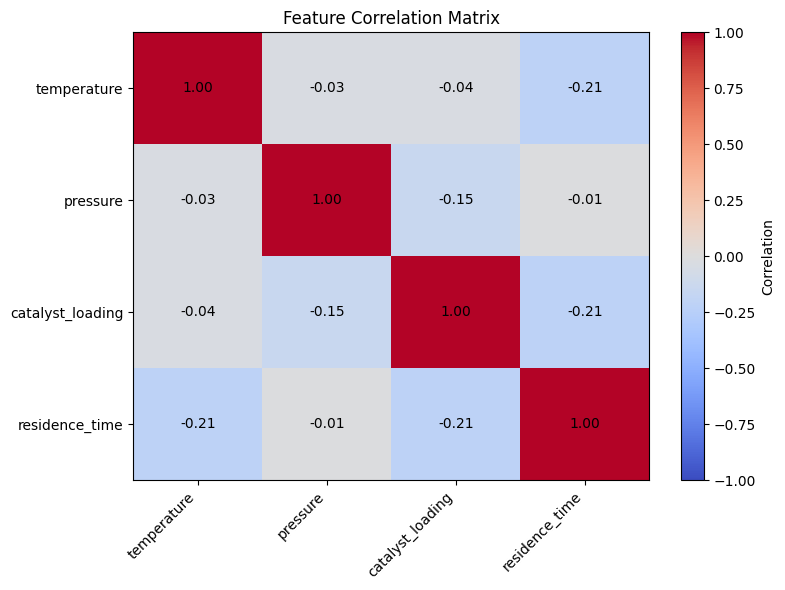

In [19]:
# Check for multicollinearity
correlation_matrix = df[feature_names].corr()

plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha='right')
plt.yticks(range(len(feature_names)), feature_names)
plt.title('Feature Correlation Matrix')

# Add correlation values
for i in range(len(feature_names)):
    for j in range(len(feature_names)):
        plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', 
                 ha='center', va='center', fontsize=10)

plt.tight_layout()
plt.show()

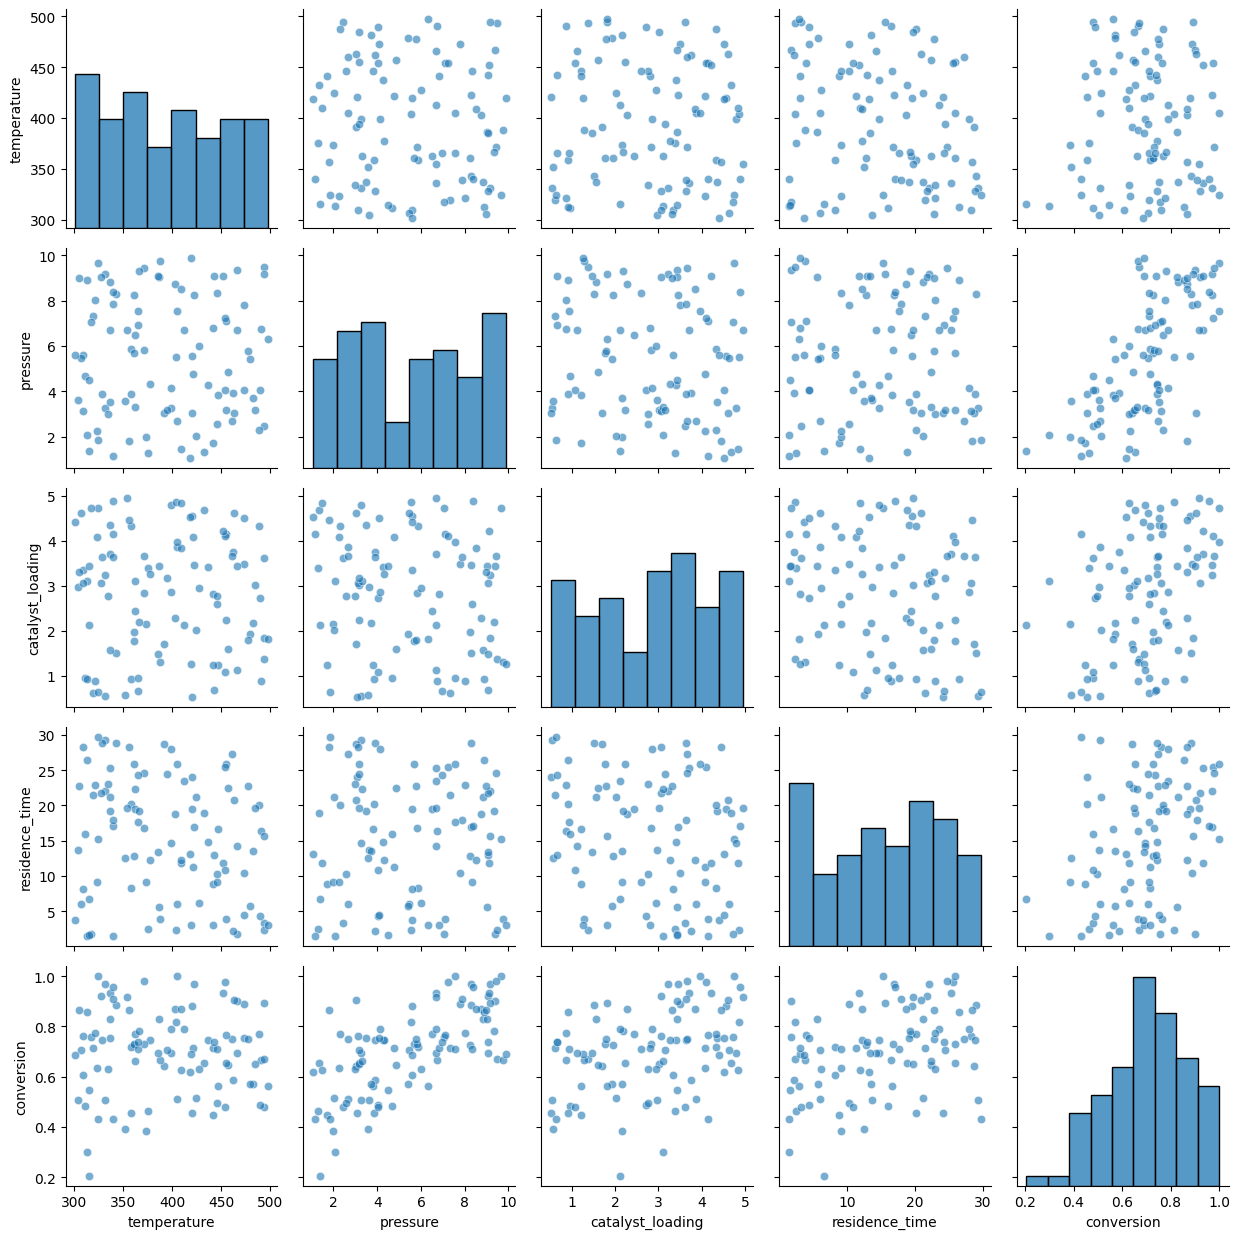

In [20]:
import seaborn as sns

sns.pairplot(df[feature_names + ['conversion']], diag_kind='hist', plot_kws={'alpha': 0.6})
plt.tight_layout()
plt.show()

## Self-Assessment Quiz

Test your understanding of linear regression concepts:

In [21]:
%pip install -q jupyterquiz
from jupyterquiz import display_quiz

display_quiz("https://raw.githubusercontent.com/jkitchin/s26-06642/main/dsmles/06-linear-regression/quizzes/linear-regression-quiz.json")

/Users/jkitchin/Dropbox/uv/.venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.


<IPython.core.display.Javascript object>

## Recommended Reading

These resources deepen understanding of linear regression and its applications:

1. **[Scikit-learn Linear Models](https://scikit-learn.org/stable/modules/linear_model.html)** - Official documentation covering ordinary least squares, Ridge, Lasso, and other linear models. Includes guidance on when to use each variant.

2. **[An Introduction to Statistical Learning, Chapter 3](https://www.statlearning.com/)** - Comprehensive treatment of linear regression including model assumptions, interpretation of coefficients, and diagnostics. Free PDF available.

3. **[Linear Regression (Penn State STAT 501)](https://online.stat.psu.edu/stat501/lesson/1)** - A complete online course on regression with detailed coverage of residual analysis, multicollinearity, and model diagnostics.

4. **[Regression and Other Stories (Gelman, Hill, Vehtari)](https://avehtari.github.io/ROS-Examples/)** - Modern treatment of regression focusing on interpretation and application. Excellent coverage of when regression works and when it doesn't.

5. **[Common Pitfalls in Machine Learning (Domingos)](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)** - Discusses overfitting, the curse of dimensionality, and why evaluating on training data gives overly optimistic results.

## Summary: The Linear Regression Workflow

Linear regression is your starting point for predictive modeling. Here's the workflow:

### The Process

1. **Explore data** → Scatter plots, correlations
2. **Split data** → Train/test (never skip this!)
3. **Fit model** → `model.fit(X_train, y_train)`
4. **Evaluate** → R², RMSE on test set
5. **Diagnose** → Check residuals for problems
6. **Interpret** → What do coefficients mean?

### Key Decisions

| Decision | Guidance |
|----------|----------|
| Feature scaling? | Yes, if you want to compare coefficient importance |
| Test set size? | 20-30% is typical; smaller datasets might use cross-validation |
| Which metric? | R² for overall fit, RMSE for error in original units |
| Add polynomial terms? | Only if residuals show curvature |

### Common Mistakes to Avoid

1. **Evaluating on training data**: Always use a held-out test set
2. **Ignoring multicollinearity**: Correlated features make coefficients unstable
3. **Extrapolating**: Be cautious predicting outside the training data range
4. **Confusing correlation with causation**: Coefficients show association, not causation

### When to Move Beyond Linear Regression

- Residuals show clear nonlinear patterns
- R² is too low despite good features
- Domain knowledge suggests nonlinear relationships
- You need feature selection (→ Lasso, next module)



---

## The Catalyst Crisis: Chapter 6 - "The Line That Explains (Almost) Everything"

*A story about linear regression and understanding model limitations*

---

"R-squared of 0.78," Alex reported to the team. "The model explains most of the variance in yield."

She'd built a proper regression model now, with domain-informed features, proper train-test splits, and cross-validation. It was a real predictive model—feed it operating conditions, get back an expected yield.

But Val Validation—the actual person, one of Professor Pipeline's teaching assistants—wasn't satisfied. She was reviewing the team's work for the weekly critique.

"Show me the residuals."

Alex pulled up the residual plot. The errors should have been random noise, scattered evenly around zero. Instead, they showed a clear pattern—larger errors at the edges, systematic under-prediction for certain conditions.

"Your model is biased," Val said flatly. "It's missing something."

"The R-squared is 0.78—"

"R-squared lies." Val pointed at the screen. "Look at *where* it fails. The worst errors are all on batches with high catalyst age. Your model doesn't know that old catalyst behaves differently."

Alex stared at the pattern she'd somehow missed. Of course. The linear model assumed catalyst age had a constant effect. But the t-SNE clustering had already shown her that old catalyst pushed batches into a different regime entirely.

"I need an interaction term," she said slowly. "Or a nonlinear model."

Val almost smiled. "Now you're asking the right question." She stood to leave. "A model that honestly shows its limitations is more valuable than one that hides them. The residuals told you where to look next. That's a feature, not a bug."

After Val left, Jordan spoke up. "I thought our model was good."

"It is good. For certain conditions." Alex marked the high-error region on the plot. "But we're extrapolating into territory where linear assumptions break down."

"So what do we do?"

Alex thought about it. The honest answer: she didn't know yet. The model was good enough to be useful but not complete. That felt uncomfortable.

"We document exactly where it works and where it doesn't," she said finally. "And we keep investigating the catalyst."

She added to the mystery board: **Linear model works, except for old catalyst. Nonlinear relationship suspected.**

---

*Continue to the next lecture to see how the team tackles classification problems...*